In [1]:
import ngmix
from ngmix.observation import Observation, ObsList, MultiBandObsList
from ngmix.fitting import LMSimple
import numpy as np
from numpy import array
from numpy.random import uniform as urand
from ngmix.bootstrap import EMRunner
import galsim
import seaborn as sns
import matplotlib.pylab as plt
import time

In [2]:
galsim.hsm.HSMParams()

galsim.hsm.HSMParams(3.0,3.6,25.0,1,2,1e-06,400,-1,0.25,8000.0,15.0,4,0.0,1.0,-1000.0)

In [3]:
def fit_line(x,y):
    params,cov = np.polyfit(x,y,1,cov = True)
    print 'slope = ', params[0], ', uncertainty = ', np.sqrt(cov[0][0])
    

In [4]:
class metacal_shear_measure:
    
    def __init__(self,final_image,psf_image):
        self.final_image = final_image
        self.final_image_array = final_image.array
        self.psf_image = psf_image
        self.psf_image_array = psf_image.array
        return None
    
    def measure_shear(self,method):
        self.results={}
        if method == 'estimateShear':
            shear = self.measure_shear_estimateShear()
        elif method == 'ngmix':
            shear = self.measure_shear_ngmix()
        elif method == 'admomBootstrap':
            shear = self.measure_shear_admombootstrap()
        self.results['g_cal'] = shear
        return 0
        
    def measure_shear_estimateShear(self):

        
        
        #get <e>
        obs_results = galsim.hsm.EstimateShear(self.final_image,self.psf_image)
        
        #prepare for get_all_metacal
        psf_obs=Observation(self.psf_image_array)
        obs = Observation(self.final_image_array,psf=psf_obs)
        
        #generate counterfactual image
        obdic = ngmix.metacal.get_all_metacal(obs,fixnoise = False)
        
        #append uncalibrated results
        self.results['g'] = (obs_results.corrected_e1/2,obs_results.corrected_e2/2)
            

        mcal_results={}

        for key in obdic:
            
            #get counterfactual PSF and image arrays
            mobs = obdic[key]
            mpsf_array = mobs.get_psf().image
            mimage_array = mobs.image
            
            #transfer counterfactual psf and image to galsim object
            this_image = galsim.Image(mimage_array)
            this_image_epsf = galsim.Image(mpsf_array)
            
            #shape measurement
            res = galsim.hsm.EstimateShear(this_image,this_image_epsf)

            this_res = {'g1':res.corrected_e1/2,'g2':res.corrected_e2/2}

            #print key,this_res
            mcal_results[key] = this_res


        # calculate response R. The shear by default
        # is 0.01, so dgamma=0.02
        
        g = np.array([obs_results.corrected_e1/2,obs_results.corrected_e2/2])
        #print g
        R11 = (mcal_results['1p']['g1'] - mcal_results['1m']['g1'])/(0.02)
        R22 = (mcal_results['2p']['g2'] - mcal_results['2m']['g2'])/(0.02)
        R12 = (mcal_results['1p']['g2'] - mcal_results['1m']['g2'])/(0.02)
        R21 = (mcal_results['2p']['g1'] - mcal_results['2m']['g1'])/(0.02)
        
        R = np.array([[R11,R12],[R21,R22]])
        Rinv = np.linalg.inv(R)
        
        #print R
        #print R11,R22
        
        #return the <g> = R^(-1) * <e>
                
        return np.matmul(Rinv,g)
    
    def measure_shear_ngmix(self):
        psf_obs=Observation(self.psf_image_array)
        pfitter=LMSimple(psf_obs,'gauss')
        pfit_guess = self.make_guess(self.psf_image_array)
        
        pfitter.go(pfit_guess)

        psf_gmix_fit=pfitter.get_gmix()
        
        psf_obs.set_gmix(psf_gmix_fit)
        
        weight=np.ones(self.final_image_array.shape)

        obs = Observation(self.final_image_array,weight = weight, psf=psf_obs)

        fitter=LMSimple(obs,'gauss')

        final_guess = self.make_guess(self.final_image_array)
        #final_guess = [0.0, 0.0, 0.01, 0.0, 50.0, 1.e5]
        
        fitter.go(final_guess)

        obs_res=fitter.get_result()
        
        self.results['g'] = obs_res['g']

        #ngmix.print_pars(obs_res['pars'],front="meas: ")
        
        obdic = ngmix.metacal.get_all_metacal(obs)
        
        mcal_results={}

        for key in obdic:
            mobs = obdic[key]
            this_psf = mobs.get_psf()
            this_image = mobs.image


            #psf fitting
            this_pfitter=LMSimple(this_psf,'gauss')
            this_pguess = self.make_guess(this_psf.image)
            this_pfitter.go(this_pguess)
            this_psf_gmix_fit=this_pfitter.get_gmix()

            # set the gmix; needed for galaxy fitting later
            this_psf.set_gmix(this_psf_gmix_fit)

            #image fitting
            weight=np.ones(this_image.shape)

            # When constructing the Observation we include a weight map and a psf
            # observation

            this_obs = Observation(this_image, weight=weight, psf=this_psf)

            this_fitter=LMSimple(this_obs,'gauss')

            this_guess = self.make_guess(this_image)
            this_fitter.go(this_guess)

            this_res=this_fitter.get_result()
            #print key,res
            mcal_results[key] = this_res
            
            #print key,this_res['g']

        R11 = (mcal_results['1p']['g'][0] - mcal_results['1m']['g'][0])/(0.02)
        R22 = (mcal_results['2p']['g'][1] - mcal_results['2m']['g'][1])/(0.02)
        R12 = (mcal_results['1p']['g'][1] - mcal_results['1m']['g'][1])/(0.02)
        R21 = (mcal_results['2p']['g'][0] - mcal_results['2m']['g'][0])/(0.02)
        R = np.array([[R11,R12],[R21,R22]])
        Rinv = np.linalg.inv(R)

        print R
        #print R11,R22
        
        return np.matmul(Rinv,obs_res['g'])
    
    
    
    def measure_shear_admombootstrap(self):
        psf_obs=Observation(self.psf_image_array)
        obs = Observation(self.final_image_array, psf=psf_obs)
        meta_boot = ngmix.bootstrap.AdmomMetacalBootstrapper(obs,fixnoise = False)
        meta_boot.fit_metacal()
        res = meta_boot.get_metacal_result()
        R11 = (res['1p']['g'][0] - res['1m']['g'][0])/(0.02)
        R22 = (res['2p']['g'][1] - res['2m']['g'][1])/(0.02)
        R12 = (res['1p']['g'][1] - res['1m']['g'][1])/(0.02)
        R21 = (res['2p']['g'][0] - res['2m']['g'][0])/(0.02)
        R = np.array([[R11,R12],[R21,R22]])
        print R
        Rinv = np.linalg.inv(R)
        e_est = res['noshear']['e']
        self.results['g'] = e_est
        
        return np.matmul(Rinv,e_est)

        
    def make_guess(self,array):
        
        eps = 0.01
        shape = galsim.hsm.FindAdaptiveMom(galsim.Image(array))
        pars = np.zeros(6)
        pars[0] = urand(low=-eps,high=eps)
        pars[1] = urand(low=-eps,high=eps)
        pars[2] = shape.observed_shape.g1+urand(low=-eps,high=eps)
        pars[3] = shape.observed_shape.g2+urand(low=-eps,high=eps)
        pars[4] = 2*shape.moments_sigma**2*(1+urand(low=-eps,high=eps))
        pars[5] = shape.moments_amp*(1+urand(low=-eps,high=eps))
        #print "guess",pars

        return pars
    
    def get_results(self):
        
        return self.results
        
        
        

In [5]:
#Truth
gal = galsim.Gaussian(sigma = 2.0,flux = 1e4)
gal = gal.shear(g1 = 0.02,g2 = 0.0)
#psf = galsim.Kolmogorov(half_light_radius=0.7)
psf = galsim.Gaussian(sigma = 0.6,flux = 1.0)
final = galsim.Convolve([gal,psf])
psf_model  =galsim.Kolmogorov(half_light_radius=0.7)

#What you can use
pixel_scale = 0.2

image_epsf = psf_model.drawImage(scale = pixel_scale)
image = final.drawImage(scale = pixel_scale)





In [6]:
metacal1 = metacal_shear_measure(image,image_epsf)
metacal1.measure_shear('estimateShear')
results1 = metacal1.get_results()
print results1



{'g_cal': array([2.04311220e-02, 1.50462198e-08]), 'g': (0.020306184887886047, 1.497972412778381e-08)}


In [7]:
pars=[0.0, 0.0, 0.01, 0.0, 50, 1.e5]
gmix0=ngmix.GMixModel(pars,"exp")
dims = [128,128]
image0 = gmix0.make_image(dims)

In [7]:
#Some test

shear_list = []
nocal_ES = []
mcal_ES = []
nocal_ng = []
mcal_ng = []
nocal_ab = []
mcal_ab = []

pixel_scale = 0.2
gal_radius = 2.0
psf_radius = 0.7
psf_model_radius = 0.7
sersic_n = 2.0
flux = 1e5


#test for shear ranging from -0.01 ~ 0.01
for i in range(20):
    #Truth
    
    this_shear = (i-10)*0.001
    
    
    gal = galsim.Sersic(sersic_n,half_light_radius = gal_radius,flux = flux)
    gal = gal.shear(g1 = this_shear , g2 = 0.0)
    psf = galsim.Kolmogorov(half_light_radius = psf_radius)

    final = galsim.Convolve([gal,psf])
    psf_model  =galsim.Kolmogorov(half_light_radius = psf_model_radius)

    #What you can use


    image_epsf = psf_model.drawImage(scale = pixel_scale)
    image = final.drawImage(scale = pixel_scale)
    
    metacal1 = metacal_shear_measure(image,image_epsf)
    metacal1.measure_shear('estimateShear')
    results1 = metacal1.get_results()
    
#     metacal2 = metacal_shear_measure(image,image_epsf)
#     metacal2.measure_shear('ngmix')
#     results2 = metacal2.get_results()
    
#     metacal3 = metacal_shear_measure(image,image_epsf)
#     metacal3.measure_shear('admomBootstrap')
#     results3 = metacal3.get_results()
    
    shear_list.append(this_shear)
    nocal_ES.append(results1['g'])
    mcal_ES.append(results1['g_cal'])
#     nocal_ng.append(results2['g'])
#     mcal_ng.append(results2['g_cal'])
#     nocal_ab.append(results3['g'])
#     mcal_ab.append(results3['g_cal'])


Text(0,0.5,'error in shear')

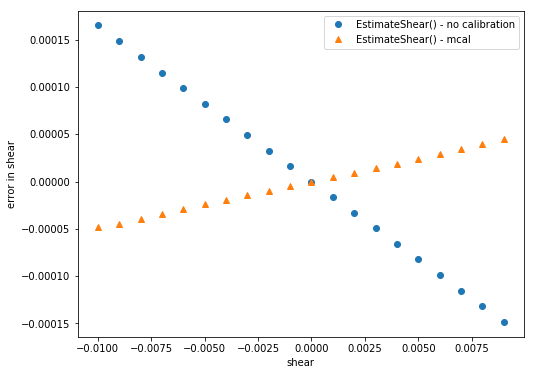

In [8]:
plt.figure(figsize = (8,6))


plt.plot(shear_list,np.array([g[0] for g in nocal_ES])-np.array(shear_list),'o',label = 'EstimateShear() - no calibration')
plt.plot(shear_list,np.array([g[0] for g in mcal_ES])-np.array(shear_list),'^',label = 'EstimateShear() - mcal')

# plt.plot(shear_list,np.array([g[0] for g in nocal_ng])-np.array(shear_list),'o',label = 'ngmix() - no calibration')
# plt.plot(shear_list,np.array([g[0] for g in mcal_ng])-np.array(shear_list),'o',label = 'ngmix() - mcal')



# plt.plot(shear_list,np.array([g[0] for g in nocal_ab])-np.array(shear_list),'o',label = 'admomBootstrap() - no calibration')
# plt.plot(shear_list,np.array([g[0] for g in mcal_ab])-np.array(shear_list),'^',label = 'admomBootstrap() - mcal')

plt.legend()

plt.xlabel('shear')
plt.ylabel('error in shear')

#plt.ylim([-0.00025,0.00025])



In [13]:
fit_line(shear_list,np.array([g[0] for g in nocal_ES])-np.array(shear_list))
fit_line(shear_list,np.array([g[0] for g in mcal_ES])-np.array(shear_list))

# fit_line(shear_list,np.array([g[0] for g in nocal_ab])-np.array(shear_list))
# fit_line(shear_list,np.array([g[0] for g in mcal_ab])-np.array(shear_list))


slope =  -0.016478976879338286 , uncertainty =  4.208227336356802e-06
slope =  0.004885463857723085 , uncertainty =  1.694239015377907e-05


1. make shear ranger larger
2. convert e to g for estimateShear
3. look into PSF fitting code
4. understand nomcal-mcal, using correct PSF


In [69]:
#Some test

shear_list = []
truth = []
nocal_ES = []
mcal_ES = []

#shear = 0.05
shear = galsim.Shear(g1=0.05)

gal_radius = 2.0
psf_radius = 0.7
psf_model_radius = 0.7

for i in range(100):
    
    #Truth
    
    intrinsic_g1 = np.random.uniform(-0.3,0.3)
    intrinsic = galsim.Shear(g1=intrinsic_g1,g2 = 0.0)
    this_shear = shear + intrinsic
    #this_shape = intrinsic+shear
    truth.append(this_shear)
    
    
    gal = galsim.Sersic(2.0,half_light_radius = gal_radius,flux = 1e5)
    #gal = gal.shear(g1 = this_shape , g2 = 0.0)
    gal = gal.shear(this_shear)
    psf = galsim.Kolmogorov(half_light_radius = psf_radius)

    final = galsim.Convolve([gal,psf])
    psf_model  =galsim.Kolmogorov(half_light_radius = psf_model_radius)

    #What you can use
    pixel_scale = 0.1

    image_epsf = psf_model.drawImage(scale = pixel_scale)
    image = final.drawImage(scale = pixel_scale)
    
    metacal1 = metacal_shear_measure(image,image_epsf)
    metacal1.measure_shear('estimateShear')
    results1 = metacal1.get_results()
    
    
    shear_list.append(this_shear)
    nocal_ES.append(results1['g'])
    mcal_ES.append(results1['g_cal'])


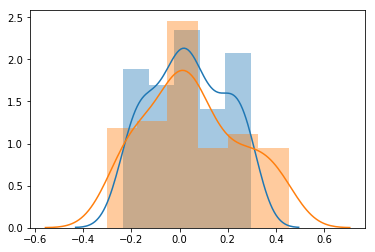

In [70]:
ES_G1_NOCAL = np.array([g[0] for g in nocal_ES])
ES_G1_MCAL = np.array([g[0] for g in mcal_ES])
truthlist = [g.g1 for g in truth]
sns.distplot(ES_G1_NOCAL)
sns.distplot(ES_G1_MCAL)

In [72]:
print truth[0].g1

0.00820699846889


(-0.0025, 0.0025)

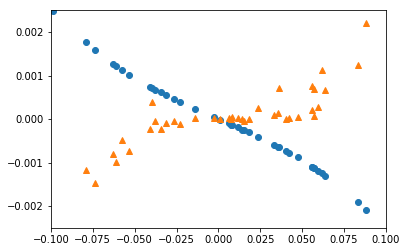

In [73]:
plt.plot(truthlist,ES_G1_NOCAL-truthlist,'o')
plt.plot(truthlist,ES_G1_MCAL-truthlist,'^')
plt.xlim([-0.1,0.1])
plt.ylim(-0.0025,0.0025)

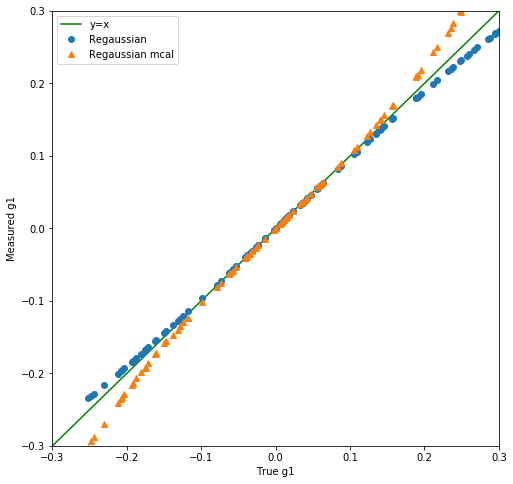

In [83]:
plt.figure(figsize = (8,8))
plt.plot([-1,1],[-1,1],color = 'green',label = 'y=x')
plt.plot(truthlist,ES_G1_NOCAL,'o',label = 'Regaussian')
plt.plot(truthlist,ES_G1_MCAL,'^',label = 'Regaussian mcal')
plt.xlim([-0.3,0.3])
plt.ylim([-0.3,0.3])
plt.xlabel('True g1')
plt.ylabel('Measured g1')
plt.legend()


In [75]:
print np.mean(ES_G1_MCAL)
print np.mean(ES_G1_NOCAL)

0.05294098553335715
0.03643890403502155
